In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data

# Set train and valid directory paths

dataset = r"C:\Users\ASUS\Inteligencia_Artificial\calsificador"
train_directory = os.path.join(dataset, 'train_pad')
valid_directory = os.path.join(dataset, 'validacion_pad')

# Batch size
bs = 1

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

7
{0: 'area_verde', 1: 'carros', 2: 'casas', 3: 'en_construccion', 4: 'establecimiento', 5: 'multivivienda', 6: 'terreno_baldio'}


In [4]:
train_data_size, valid_data_size

(1690, 1804)

In [5]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
for param in alexnet.parameters():
    param.requires_grad = False

In [7]:
# Change the final layer of AlexNet Model for Transfer Learning
# alexnet.classifier[6] = nn.Linear(4096, 800)
# # alexnet.classifier[7] = nn.Linear(800, num_classes)
# # alexnet.classifier[8] =nn.Softmax()
# alexnet.classifier.add_module("7", nn.Linear(800, num_classes))
# # alexnet.classifier.add_module("8",nn.Softmax())
# alexnet.classifier.add_module("8", nn.LogSoftmax(dim = 1))
# alexnet

In [8]:
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
summary(alexnet, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

In [10]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
#loss_func=nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=0.0001,params=alexnet.parameters())#alexnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [11]:

def train_and_validate(model, loss_criterion, optimizer, epochs=25,device=0):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in tqdm.tqdm(enumerate(train_data_loader),total=len(train_data_loader)):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in tqdm.tqdm(enumerate(valid_data_loader),total=len(valid_data_loader)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)
                
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [12]:
##restore_checkpoint
# checkpoint=torch.load(r"C:\Users\ASUS\Inteligencia_Artificial\calsificador\ckpoint\best_model1.pth")
# alexnet.load_state_dict(checkpoint['model_state_dict'])

In [13]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")
# device = torch.device(0)
num_epochs =15
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/15


100%|██████████| 1804/1804 [00:13<00:00, 131.97it/s]


Epoch : 001, Training: Loss: 1.0130, Accuracy: 64.7337%, 
		Validation : Loss : 0.8118, Accuracy: 70.2328%, Time: 28.5011s
Epoch: 2/15


100%|██████████| 1804/1804 [00:16<00:00, 112.30it/s]


Epoch : 002, Training: Loss: 0.8159, Accuracy: 71.2426%, 
		Validation : Loss : 0.6549, Accuracy: 83.2040%, Time: 33.7508s
Epoch: 3/15


100%|██████████| 1804/1804 [00:14<00:00, 120.45it/s]


Epoch : 003, Training: Loss: 0.7696, Accuracy: 72.0118%, 
		Validation : Loss : 0.6094, Accuracy: 82.2616%, Time: 30.8186s
Epoch: 4/15


100%|██████████| 1804/1804 [00:15<00:00, 115.72it/s]


Epoch : 004, Training: Loss: 0.7267, Accuracy: 73.6095%, 
		Validation : Loss : 0.4411, Accuracy: 90.0776%, Time: 32.7138s
Epoch: 5/15


100%|██████████| 1804/1804 [00:17<00:00, 106.09it/s]


Epoch : 005, Training: Loss: 0.7144, Accuracy: 74.1420%, 
		Validation : Loss : 0.3447, Accuracy: 92.0732%, Time: 34.0600s
Epoch: 6/15


100%|██████████| 1804/1804 [00:14<00:00, 121.58it/s]


Epoch : 006, Training: Loss: 0.7052, Accuracy: 73.8462%, 
		Validation : Loss : 0.4598, Accuracy: 87.3614%, Time: 37.0181s
Epoch: 7/15


100%|██████████| 1804/1804 [00:16<00:00, 108.61it/s]


Epoch : 007, Training: Loss: 0.6992, Accuracy: 75.4438%, 
		Validation : Loss : 0.3872, Accuracy: 88.9690%, Time: 32.0011s
Epoch: 8/15


100%|██████████| 1804/1804 [00:14<00:00, 124.56it/s]


Epoch : 008, Training: Loss: 0.6897, Accuracy: 76.0947%, 
		Validation : Loss : 0.4714, Accuracy: 85.3104%, Time: 29.4024s
Epoch: 9/15


100%|██████████| 1804/1804 [00:14<00:00, 121.87it/s]


Epoch : 009, Training: Loss: 0.7005, Accuracy: 74.8521%, 
		Validation : Loss : 0.4605, Accuracy: 87.0288%, Time: 30.2165s
Epoch: 10/15


100%|██████████| 1804/1804 [00:14<00:00, 121.95it/s]


Epoch : 010, Training: Loss: 0.6813, Accuracy: 73.4320%, 
		Validation : Loss : 0.4022, Accuracy: 87.1951%, Time: 31.1041s
Epoch: 11/15


100%|██████████| 1804/1804 [00:17<00:00, 103.84it/s]


Epoch : 011, Training: Loss: 0.6656, Accuracy: 74.7929%, 
		Validation : Loss : 0.5872, Accuracy: 74.1685%, Time: 32.7243s
Epoch: 12/15


100%|██████████| 1804/1804 [00:16<00:00, 110.36it/s]


Epoch : 012, Training: Loss: 0.6756, Accuracy: 74.7337%, 
		Validation : Loss : 0.4620, Accuracy: 85.5876%, Time: 32.2117s
Epoch: 13/15


100%|██████████| 1804/1804 [00:15<00:00, 114.25it/s]


Epoch : 013, Training: Loss: 0.6535, Accuracy: 76.1538%, 
		Validation : Loss : 0.7804, Accuracy: 63.2483%, Time: 31.2887s
Epoch: 14/15


100%|██████████| 1804/1804 [00:22<00:00, 78.45it/s] 


Epoch : 014, Training: Loss: 0.6760, Accuracy: 74.9704%, 
		Validation : Loss : 0.4470, Accuracy: 86.9734%, Time: 40.8484s
Epoch: 15/15


100%|██████████| 1804/1804 [00:15<00:00, 116.49it/s]

Epoch : 015, Training: Loss: 0.6848, Accuracy: 74.2012%, 
		Validation : Loss : 0.5378, Accuracy: 80.9313%, Time: 30.8962s


In [14]:
ñ

NameError: name 'ñ' is not defined

In [21]:
for j, (inputs, labels) in tqdm.tqdm(enumerate(valid_data_loader),total=len(valid_data_loader)):
    print(inputs)

  1%|▏         | 23/1804 [00:00<00:08, 220.71it/s]

tensor([[[[0.1843, 0.1765, 0.1647,  ..., 0.3255, 0.3294, 0.3373],
          [0.1882, 0.1804, 0.1725,  ..., 0.3176, 0.3255, 0.3373],
          [0.1961, 0.1882, 0.1765,  ..., 0.3137, 0.3216, 0.3373],
          ...,
          [0.7412, 0.7176, 0.6902,  ..., 0.4706, 0.4706, 0.4745],
          [0.7451, 0.7216, 0.6941,  ..., 0.5176, 0.5216, 0.5255],
          [0.7451, 0.7216, 0.6980,  ..., 0.5647, 0.5686, 0.5725]],

         [[0.1765, 0.1686, 0.1608,  ..., 0.3490, 0.3490, 0.3608],
          [0.1804, 0.1725, 0.1686,  ..., 0.3412, 0.3451, 0.3569],
          [0.1843, 0.1765, 0.1725,  ..., 0.3333, 0.3412, 0.3569],
          ...,
          [0.6196, 0.5961, 0.5647,  ..., 0.4510, 0.4510, 0.4549],
          [0.6235, 0.6000, 0.5686,  ..., 0.4980, 0.5020, 0.5059],
          [0.6235, 0.6000, 0.5725,  ..., 0.5451, 0.5490, 0.5529]],

         [[0.1686, 0.1608, 0.1569,  ..., 0.2627, 0.2627, 0.2706],
          [0.1765, 0.1686, 0.1608,  ..., 0.2549, 0.2588, 0.2706],
          [0.1804, 0.1725, 0.1647,  ..., 0

  4%|▍         | 74/1804 [00:00<00:08, 195.92it/s]

tensor([[[[0.7255, 0.7255, 0.6745,  ..., 0.5922, 0.5922, 0.5569],
          [0.7333, 0.7333, 0.6784,  ..., 0.5922, 0.5922, 0.5569],
          [0.7373, 0.7373, 0.6824,  ..., 0.5922, 0.5922, 0.5569],
          ...,
          [0.6510, 0.6510, 0.6549,  ..., 0.2824, 0.2824, 0.2627],
          [0.6549, 0.6549, 0.6588,  ..., 0.2667, 0.2667, 0.2510],
          [0.6588, 0.6588, 0.6588,  ..., 0.2549, 0.2549, 0.2392]],

         [[0.7020, 0.7020, 0.6510,  ..., 0.4392, 0.4392, 0.4118],
          [0.7059, 0.7059, 0.6549,  ..., 0.4353, 0.4353, 0.4078],
          [0.7098, 0.7098, 0.6588,  ..., 0.4314, 0.4314, 0.4039],
          ...,
          [0.6039, 0.6039, 0.6039,  ..., 0.2431, 0.2431, 0.2275],
          [0.6078, 0.6078, 0.6078,  ..., 0.2275, 0.2275, 0.2118],
          [0.6118, 0.6118, 0.6078,  ..., 0.2157, 0.2157, 0.2039]],

         [[0.6667, 0.6667, 0.6157,  ..., 0.3804, 0.3804, 0.3569],
          [0.6706, 0.6706, 0.6157,  ..., 0.3765, 0.3765, 0.3529],
          [0.6706, 0.6706, 0.6196,  ..., 0

  7%|▋         | 126/1804 [00:00<00:07, 228.86it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

  8%|▊         | 153/1804 [00:00<00:06, 241.71it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 11%|█▏        | 207/1804 [00:00<00:06, 253.77it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 14%|█▍        | 259/1804 [00:01<00:06, 254.83it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0.3137, 0.3294, 0.3373,  ..., 0.1098, 0.1137, 0.1137],
          [0.3137, 0.3255, 0.3333,  ..., 0.1176, 0.1216, 0.1216],
          [0.3098, 0.3216, 0.3294,  ..., 0.1294, 0.1294, 0.1

 17%|█▋        | 311/1804 [00:01<00:05, 253.28it/s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4157, 0.4157, 0.4157,  ..., 0.3882, 0.3922, 0.3961],
          [0.5137, 0.5137, 0.5098,  ..., 0.4784, 0.4824, 0.4863],
          ...,
          [0.2902, 0.3176, 0.3608,  ..., 0.5137, 0.5176, 0.5216],
          [0.2353, 0.2588, 0.2941,  ..., 0.4157, 0.4196, 0.4235],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4157, 0.4157, 0.4118,  ..., 0.3373, 0.3412, 0.3490],
          [0.5098, 0.5098, 0.5059,  ..., 0.4157, 0.4196, 0.4235],
          ...,
          [0.1647, 0.2000, 0.2471,  ..., 0.5373, 0.5412, 0.5451],
          [0.1333, 0.1608, 0.2000,  ..., 0.4353, 0.4392, 0.4431],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4000, 0.4000, 0.3961,  ..., 0.3333, 0.3333, 0.3373],
          [0.4902, 0.4902, 0.4863,  ..., 0

 19%|█▊        | 337/1804 [00:01<00:05, 246.72it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 20%|██        | 362/1804 [00:01<00:07, 187.62it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 22%|██▏       | 404/1804 [00:01<00:07, 192.24it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 25%|██▍       | 449/1804 [00:02<00:06, 202.90it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 27%|██▋       | 496/1804 [00:02<00:06, 216.10it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
         

 30%|███       | 544/1804 [00:02<00:05, 222.81it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5176, 0.5176, 0.5176,  ..., 0.2902, 0.3020, 0.3216],
          [0.6392, 0.6392, 0.6392,  ..., 0.3569, 0.3725, 0.3

KeyboardInterrupt: 

In [15]:
torch.save({    'epoch': 111,
                'model_state_dict': alexnet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, r'C:\Users\ASUS\Inteligencia_Artificial\calsificador\ckpoint/best_model1.pth')

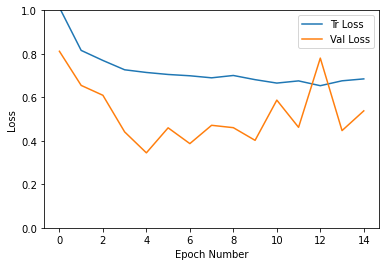

In [16]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

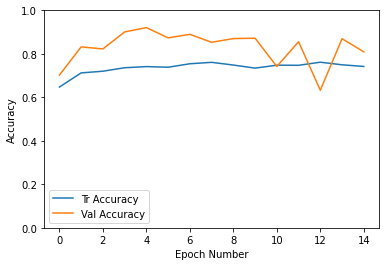

In [17]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

PREDICCIÓN

In [ ]:
#Librerías
import cv2
import torch,torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
from torchvision import models
from torchsummary import summary


Diccionario de clases

In [ ]:
idx_to_class={0: 'area_verde', 1: 'carros', 2: 'casas', 3: 'en_construccion', 4: 'establecimiento', 5: 'multivivienda', 6: 'terreno_baldio'}
# Get a mapping of the indices to the class names, in order to see the ou

In [26]:
def predict_Alberto(file,model,pad=False):
    x = Image.open(file)
    x = np.asarray(x)
    # if pad:
    #     x=add_pad(x)
    # else:
    x=cv2.resize(x,(224,224))
    x=x.astype("float32")
    x=x/255
    x=np.moveaxis(x,-1,0)
    x = np.expand_dims(x, axis=0)
    img = torch.from_numpy(x).to(device)
    res=list(model(img).cpu().detach().numpy()[0])
    indice=res.index(max(res))
    clase=idx_to_class.get(indice)
    # print(clase)
    return clase 

In [46]:
import cv2
file=r"C:\Users\ASUS\Inteligencia_Artificial\calsificador\validacion_pad\casas\4_2.png"
clase=predict_Alberto(file,alexnet)
imagen=cv2.imread(file)
font = cv2.FONT_HERSHEY_SIMPLEX
org = (10, 50)
fontScale = 1
color = (0, 0, 224)
thickness = 2
image = cv2.putText(imagen, clase, org, font, fontScale, color, thickness, cv2.LINE_AA)
cv2.imshow("imagen",imagen)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
alexnet1 = models.alexnet(pretrained=True)
alexnet1

In [ ]:
for param in alexnet1.parameters():
    param.requires_grad = False

In [ ]:
# Change the final layer of AlexNet Model for Transfer Learning
num_classes=6
alexnet1.classifier[6] = nn.Linear(4096, num_classes)
alexnet1.classifier.add_module("7", nn.LogSoftmax(dim = 1))


In [ ]:
summary(alexnet1, (3, 224, 224))

In [ ]:
file=r"C:\Users\ASUS\Inteligencia_Artificial\calsificador\train\en_construccion\Lerma_1.PNG"

In [ ]:
x = cv2.imread(file)
x=cv2.resize(x,(224,224))
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = np.asarray(x)
x=x.astype("float32")
x=np.moveaxis(x,-1,0)
x = np.expand_dims(x, axis=0)
img = torch.from_numpy(x).to(device=device)
res=list(alexnet(img).cpu().detach().numpy()[0])
indice=res.index(max(res))
clase=idx_to_class.get(indice)
print(clase) 

In [ ]:
alexnet1 = models.alexnet(pretrained=False)
checkpoint=torch.load(r"C:\Users\ASUS\Inteligencia_Artificial\calsificador\ckpoint\best_model.pth")

In [ ]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")

In [ ]:
# predict_Alberto(file=file, model=alexnet1)

In [ ]:
for param in alexnet1.parameters():
    param.requires_grad = False

In [ ]:
# Change the final layer of AlexNet Model for Transfer Learning
num_classes=6
alexnet1.classifier[6] = nn.Linear(4096, num_classes)
alexnet1.classifier.add_module("7", nn.LogSoftmax(dim = 1))

#alexnet1.eval()

alexnet1

In [ ]:
summary(alexnet1, (3, 224, 224))

In [ ]:
alexnet1.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# file=r"C:\Users\mfpen\Pictures\Clasificador\train\area_verde\605_1.png"
file=r"C:\Users\ASUS\Inteligencia_Artificial\calsificador\train_pad\casas\63_11.png"
import cv2
x = cv2.imread(file)
x=cv2.resize(x,(224,224))
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = np.asarray(x)
x=x.astype("float32")
x=np.moveaxis(x,-1,0)
x = np.expand_dims(x, axis=0)
img = torch.from_numpy(x).to(device)
res=list(alexnet1(img).cpu().detach().numpy()[0])
indice=res.index(max(res))
clase=idx_to_class.get(indice)
print(clase) 